# Earth2MIP Demo - Custom Datasets

In this demo, we will run some of the models available from the Earth2MIP package.

**Note**: You will need to have already downloaded the data so see tutorial 1.2.1 for more information about how one can do this using this package.

In this demo, we will do the following:
* Choose a Model for Inference
* Load the Data using the custom xarray dataset loader
* Apply the Model on the custom dataset for forecasting

In this demo, we will **not do** the following:
* Analysis of the Results


**Note**: Please following the instructions on how to install the repo that are in the README.
In theory, they should work as I have tested it multiple times on a linux machine with a GPU. But there are never any guarantees...

In [1]:
import numpy as np
import cdsapi
from pathlib import Path
import xarray as xr
import autoroot
import datetime
from pprint import pprint
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ddf._src.data.local.xrda import LocalDataSourceXArray

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

First, we need to select a model.
This will depend on what you choose to install. 
I personally chose the `FourCastNet` model because it is the most flexible in terms of resolution (in theory). 
But in principal, we could choose other models but it would depend on the variables.

In [2]:
model_name = "fcnv2_sm" #"pangu_6" # 

We can get the channel names which are already stored previously within the package.

In [3]:
from ddf._src.models.variables import EARTH2MIP_MODEL_VARIABLES

# channel_names = EARTH2MIP_MODEL_VARIABLES["fcnv2_sm"]
channel_names = EARTH2MIP_MODEL_VARIABLES[model_name]

First, we need to load the model and put it to some processor, either `cpu` or some `cuda:x` device.

**Warning**: CPU is very slow even for inference.
It's not recommended.

In [4]:
model = f"e2mip://{model_name}"
device = "cuda:0"

We initialize a special `earth2mip.networks.Inference` datastructure which has a host of different features for making predictions.
The most important thing is initializing a model from their registry or a custom model and of course the device.
This step can take a while if it is the first time you are using the model you call.

In [5]:
time_loop  = get_model(
    model=model,
    device=device,
)

We can check to make sure that the channel names that they find within Earth2MIP are the same as the channel names.

In [6]:
# get channel names that they have parsed
channel_names_ = time_loop.in_channel_names
# check
print(f"Out Channel Names:\n", sorted(channel_names))
print(f"Earth2MIP Channel Names:\n", sorted(channel_names_))

Out Channel Names:
 ['msl', 'r100', 'r1000', 'r150', 'r200', 'r250', 'r300', 'r400', 'r50', 'r500', 'r600', 'r700', 'r850', 'r925', 'sp', 't100', 't1000', 't150', 't200', 't250', 't2m', 't300', 't400', 't50', 't500', 't600', 't700', 't850', 't925', 'tcwv', 'u100', 'u1000', 'u100m', 'u10m', 'u150', 'u200', 'u250', 'u300', 'u400', 'u50', 'u500', 'u600', 'u700', 'u850', 'u925', 'v100', 'v1000', 'v100m', 'v10m', 'v150', 'v200', 'v250', 'v300', 'v400', 'v50', 'v500', 'v600', 'v700', 'v850', 'v925', 'z100', 'z1000', 'z150', 'z200', 'z250', 'z300', 'z400', 'z50', 'z500', 'z600', 'z700', 'z850', 'z925']
Earth2MIP Channel Names:
 ['msl', 'r100', 'r1000', 'r150', 'r200', 'r250', 'r300', 'r400', 'r50', 'r500', 'r600', 'r700', 'r850', 'r925', 'sp', 't100', 't1000', 't150', 't200', 't250', 't2m', 't300', 't400', 't50', 't500', 't600', 't700', 't850', 't925', 'tcwv', 'u100', 'u1000', 'u100m', 'u10m', 'u150', 'u200', 'u250', 'u300', 'u400', 'u50', 'u500', 'u600', 'u700', 'u850', 'u925', 'v100', 'v100

***

## Initial Condition

We need to do an initial condition to propagate the data forward.
We will use a special `dataclass` which defines all of the parameters we need to load data from an `xarray.Dataset`.
This should include `.netcdf`, `.grib`, and `.grib`. 
As long as we can define the xarray engine and it follows some standards, we should be able to load it.

**Parameters**

* `t0` - `datetime` object with a time period.
* `num_steps` - the number of time steps (6h intervals)

In [7]:
# starting timestep
t0 = datetime.datetime(2018,7,30)
print(f"Start Time (t0): {t0}")

# number of forecast steps
num_steps = 4 * 12 # 6h intervals

print(f"Number of Steps: {num_steps}")

Start Time (t0): 2018-07-30 00:00:00
Number of Steps: 48


## Custom Datasets

### NETCDF Files

Our first example will have a custom `.netcdf` file where we already have the variables available.
We need to specify where the files are located.
Simply make a list of files to be parsed.

**Note**: These can be multiple files as I have shown here.
Under the hood, the code will loop through each of the files until every variable that it needs is found.
This is useful if you want to separate your files in a different way.
In this example, we have separated the files into single-levels and pressure-levels as from the previous notebook.

In [8]:
save_name_sl = Path("reanalysis-202108010000-sl.nc")
save_name_pl = Path("reanalysis-202108010000-pl.nc")
save_path = Path("/pool/proyectos/CLINT/sa4attrs/data/raw/events/test/")

file_paths = [
    save_path.joinpath(save_name_sl),
    save_path.joinpath(save_name_pl),
]
file_paths

[PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/events/test/reanalysis-202108010000-sl.nc'),
 PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/events/test/reanalysis-202108010000-pl.nc')]

In [9]:
ds = xr.open_mfdataset(file_paths, combine="by_coords", engine="netcdf4")
ds

<xarray.Dataset> Size: 714MB
Dimensions:    (longitude: 1440, latitude: 721, time: 1, level: 13)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 8B 2021-08-01
  * level      (level) int32 52B 100 1000 200 300 400 50 ... 150 600 250 700 925
Data variables: (12/14)
    v10        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u10        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    v100       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    msl        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...         ...
    z          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    q          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    t          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    r          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    u          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-26 15:52:58 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

#### Parameters

We have some key parameters we need to set when dealing with this dataset.

**Name Convention**.
The name convention follows the *full name*, e.g., "10m_u_component_of_wind". This convention is set by the CDS, e.g., "u10".
We have a database within the library for all variables that are related to the AI models so it will recognize all names and do the translation even though we provided a list of `channel_names` which have the short form format.

**Pressure Name**.
We need to specify what is the pressure level name. 
This varies across datasets so the user can manually specify it to match theirs.

**Engine**.
We use the native `xarray.open_mfdataset(..., engine=...)` function.
So we are free to specify whichever engine that is our dataset format.
Even though this example uses `.netcdf`, we are also compatible with whichever formats are available.

In [10]:
# initial condition
data_source_xr = LocalDataSourceXArray(
    channel_names=channel_names,
    file_paths=file_paths,
    pressure_name="level", 
    name_convention="short_name", # era5_name
    engine="netcdf4", 
    
)

We can check to make sure that this works by slicing the `data_source_xr` object with our time of interest.

In [11]:
out_xr = data_source_xr[t0]

...and we can plot it to make sure it's ok.

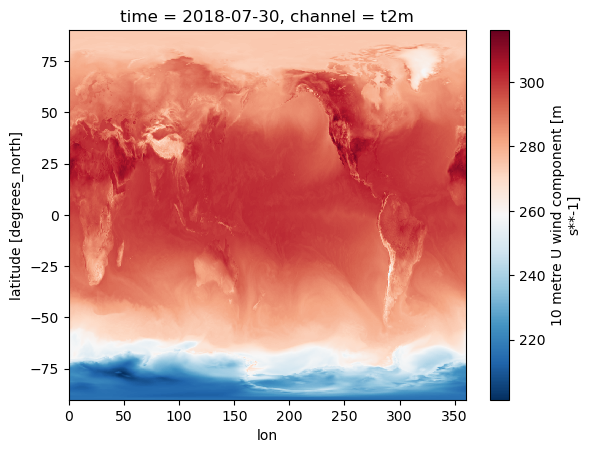

In [12]:
out_xr.sel(channel="t2m").plot(cmap="RdBu_r")

## Inference Loop

These are the same steps as the first tutorial where one could download the data directly from CDSAPI.
This might take a while depending upon your resources.

In [13]:
%%time
ds_pred = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source_xr, 
    time=t0
)

CPU times: user 15.1 s, sys: 21.1 s, total: 36.2 s
Wall time: 38.6 s


In [14]:
ds_pred_plot = ds_pred.sel(channel="t2m")

We can plot it just to make sure the output makes sense.

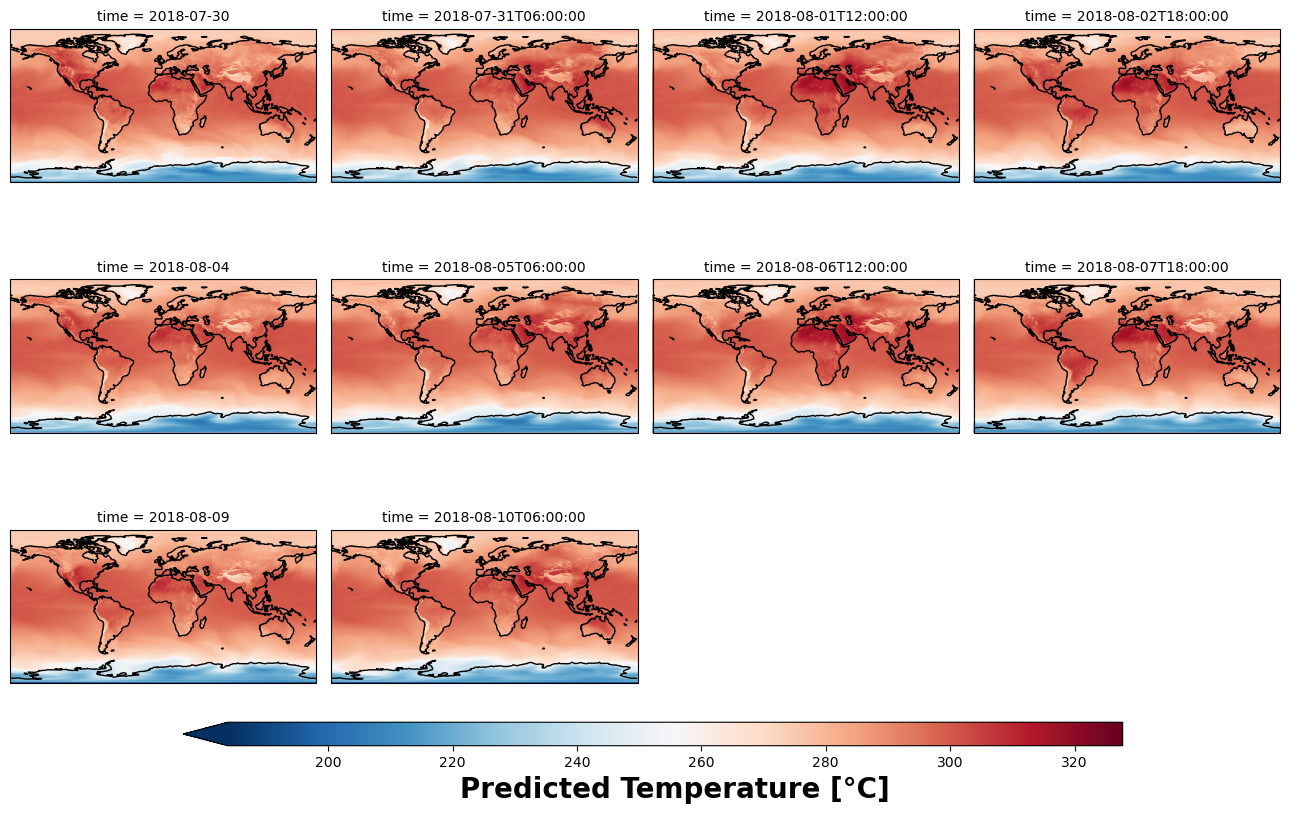

In [15]:
vmin, vmax = ds_pred_plot.min().values, ds_pred_plot.max().values
vmin -= - 0.02 * vmin
vmax += 0.02 * vmax
cmap = "RdBu_r"

fig = ds_pred_plot.isel(time=slice(None,None,5)).squeeze().plot.pcolormesh(
    col="time", col_wrap=4, cmap=cmap,
    vmin=vmin, vmax=vmax,
    transform=ccrs.PlateCarree(),
    subplot_kws={
        "projection": ccrs.PlateCarree(),
        # "xlim":[ds.lon.values.min(), ds.lon.values.max()],
        # "ylim": [ds.latitude.values.min(), ds.latitude.values.max()],
    },
    # usual xarray stuff
    cbar_kwargs={
        "orientation": "horizontal", 
        # "shrink": 0.8, "aspect": 40, 
        "fraction": 0.027, "pad": 0.045, "aspect": 40,
    },
    robust=False,
)
fig.map(lambda: plt.gca().coastlines())
fig.cbar.set_label(label=f'Predicted Temperature [°C]', size=20, weight='bold')
# plt.tight_layout()
plt.show()